In [11]:
# --- Jupyter Starter Pack ---

# autoreload: refresh code on every cell run
%reload_ext autoreload
%autoreload 2

# clean warnings
import warnings
warnings.filterwarnings("ignore")

# numpy / pandas nicer display
import numpy as np
np.set_printoptions(precision=4, suppress=True)

# matplotlib defaults
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 120

# tqdm in notebooks
from tqdm.notebook import tqdm

# optional: make exceptions show only the important frame
%config InlineBackend.figure_format = "retina"

import torch, gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# --- 1. The Physics (Differentiable Forward Kinematics) ---
# This acts as the "Aggregator" from the paper.
# It maps the Latent State (Angles) -> Observed State (Hand Position)
def forward_kinematics(theta):
    # theta shape: [batch, 2] (shoulder, elbow)
    # Link lengths assumed to be 1.0 each
    l1, l2 = 1.0, 1.0
    
    t1 = theta[:, 0]
    t2 = theta[:, 1]
    
    # Simple trigonometry
    x = l1 * torch.cos(t1) + l2 * torch.cos(t1 + t2)
    y = l1 * torch.sin(t1) + l2 * torch.sin(t1 + t2)
    
    return torch.stack([x, y], dim=1)

In [13]:
# --- 2. The Control Network ---
# Takes current angles + time -> outputs torque/velocity adjustments
class ControlNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: 4 angles + 1 time = 5 dims
        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 4) # Output: 4 control signals (2 for Arm A, 2 for Arm B)
        )
    
    def forward(self, state, t):
        # state is [batch, 4]
        xt = torch.cat([state, t], dim=1)
        return self.net(xt)

In [5]:
# --- 3. The "Pretrained" Priors (The Drifts) ---
# Arm A loves resting at 135 degrees (Left)
# Arm B loves resting at 45 degrees (Right)
def drift_arm_A(theta): 
    target = torch.tensor([np.pi*0.75, 0.0]) # Resting pose Left
    return -1.0 * (theta - target)

def drift_arm_B(theta):
    target = torch.tensor([np.pi*0.25, 0.0]) # Resting pose Right
    return -1.0 * (theta - target)


--- Training Robotic Coordination ---
Epoch 0: Dist Loss 2.0569
Epoch 50: Dist Loss 0.0835
Epoch 100: Dist Loss 0.0389
Epoch 150: Dist Loss 0.0365
Epoch 200: Dist Loss 0.0381
Epoch 250: Dist Loss 0.0247
Epoch 300: Dist Loss 0.0237
Epoch 350: Dist Loss 0.0409
Epoch 400: Dist Loss 0.0272
Epoch 450: Dist Loss 0.0252
Epoch 500: Dist Loss 0.0219
Epoch 550: Dist Loss 0.0236
Epoch 600: Dist Loss 0.0234
Epoch 650: Dist Loss 0.0414
Epoch 700: Dist Loss 0.0264
Epoch 750: Dist Loss 0.0205
Epoch 800: Dist Loss 0.0285
Epoch 850: Dist Loss 0.0294
Epoch 900: Dist Loss 0.0207
Epoch 950: Dist Loss 0.0452

Visualizing Result...


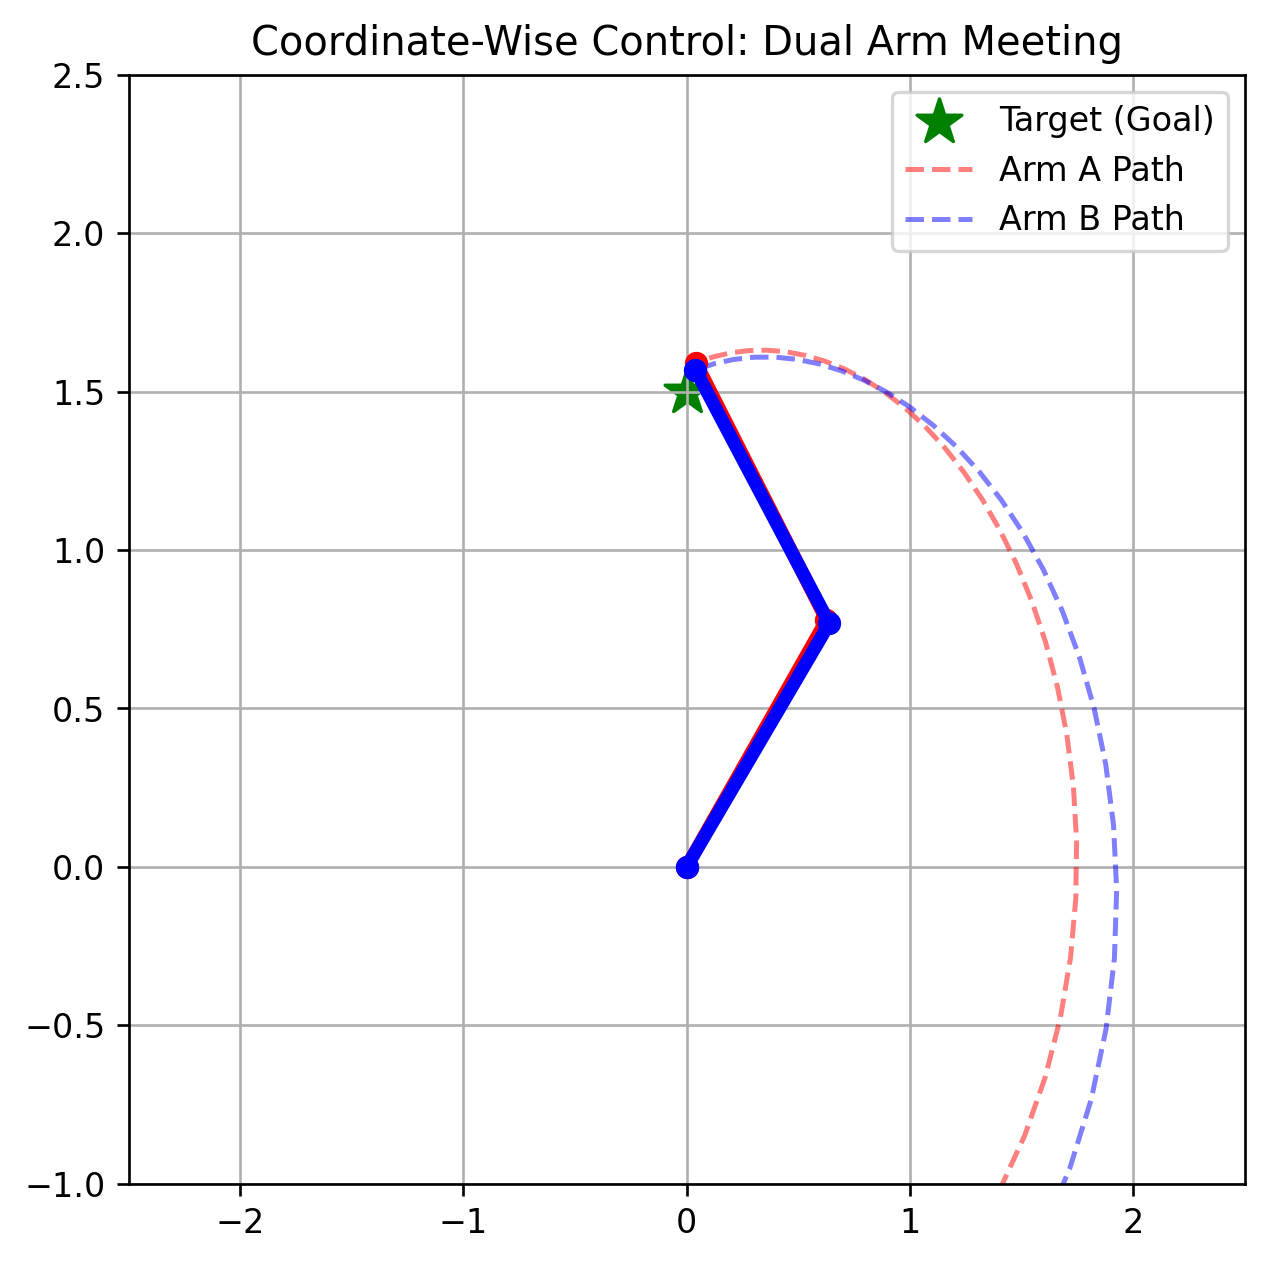

In [ ]:
# --- 4. Training Loop ---
steps = 30
dt = 1.0 / steps
batch_size = 64
epochs = 1000

ctrl = ControlNet()
optimizer = optim.Adam(ctrl.parameters(), lr=0.01)
target_meet_point = torch.tensor([0.0, 1.5]) # High Center (Hard to reach for both)

print("--- Training Robotic Coordination ---")

for epoch in range(epochs):
    optimizer.zero_grad()
    
    state = torch.randn(batch_size, 4)     
    control_energy = 0
    
    for i in range(steps):
        t = torch.full((batch_size, 1), i * dt)
        
        u = ctrl(state, t) # u is [batch, 4]
        u_A = u[:, 0:2]
        u_B = u[:, 2:4]
        
        # B. Get Natural Drifts
        state_A = state[:, 0:2]
        state_B = state[:, 2:4]
        
        b_A = drift_arm_A(state_A)
        b_B = drift_arm_B(state_B)
        
        noise = torch.randn_like(state) * np.sqrt(dt) * 0.1
        
        # Combined drift
        total_drift = torch.cat([b_A + u_A, b_B + u_B], dim=1)
        
        state = state + total_drift * dt + noise
        
        # Regularize control effort
        control_energy += torch.mean(u**2) * dt

    # --- Terminal Cost ---
    # 1. Compute Hand Positions (The Aggregation)
    pos_A = forward_kinematics(state[:, 0:2])
    pos_B = forward_kinematics(state[:, 2:4])
    
    # 2. Loss: Both hands must be at the Target Point
    dist_loss = torch.mean((pos_A - target_meet_point)**2 + (pos_B - target_meet_point)**2)
    
    loss = dist_loss + 0.05 * control_energy
    
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Dist Loss {dist_loss.item():.4f}")

# --- 5. Visualization (Inference) ---
print("\nVisualizing Result...")
ctrl.eval()
with torch.no_grad():
    # Simulate one trajectory
    state = torch.randn(1, 4)
    traj_A = []
    traj_B = []
    
    for i in range(steps):
        t = torch.full((1, 1), i * dt)
        u = ctrl(state, t)
        
        b_A = drift_arm_A(state[:, 0:2])
        b_B = drift_arm_B(state[:, 2:4])
        
        drift = torch.cat([b_A + u[:,:2], b_B + u[:,2:]], dim=1)
        state = state + drift * dt
        
        # Store for plotting (convert angles to xy)
        xy_A = forward_kinematics(state[:, 0:2])
        xy_B = forward_kinematics(state[:, 2:4])
        traj_A.append(xy_A[0].numpy())
        traj_B.append(xy_B[0].numpy())

traj_A = np.array(traj_A)
traj_B = np.array(traj_B)

plt.figure(figsize=(6, 6))
# Plot Target
plt.scatter(0, 1.5, c='green', s=200, marker='*', label='Target (Goal)')

# Plot Trajectories
plt.plot(traj_A[:,0], traj_A[:,1], 'r--', alpha=0.5, label='Arm A Path')
plt.plot(traj_B[:,0], traj_B[:,1], 'b--', alpha=0.5, label='Arm B Path')

# Plot Final Arm Poses
final_theta = state[0]
def plot_arm(theta, color, label):
    l1, l2 = 1.0, 1.0
    x1 = l1 * np.cos(theta[0])
    y1 = l1 * np.sin(theta[0])
    x2 = x1 + l2 * np.cos(theta[0]+theta[1])
    y2 = y1 + l2 * np.sin(theta[0]+theta[1])
    plt.plot([0, x1, x2], [0, y1, y2], color=color, linewidth=4, marker='o')

plot_arm(final_theta[0:2].numpy(), 'red', 'Arm A')
plot_arm(final_theta[2:4].numpy(), 'blue', 'Arm B')

plt.xlim(-2.5, 2.5)
plt.ylim(-1, 2.5)
plt.title("Coordinate-Wise Control: Dual Arm Meeting")
plt.legend()
plt.grid(True)
plt.show()

Epoch 0: Dist 2.4555 | Wall Violation 1.3078
Epoch 50: Dist 0.6997 | Wall Violation 0.1174
Epoch 100: Dist 0.2668 | Wall Violation 0.0779
Epoch 150: Dist 0.1058 | Wall Violation 0.0564
Epoch 200: Dist 0.0632 | Wall Violation 0.0908
Epoch 250: Dist 0.0541 | Wall Violation 0.0409
Epoch 300: Dist 0.0349 | Wall Violation 0.0289
Epoch 350: Dist 0.0333 | Wall Violation 0.0387
Epoch 400: Dist 0.0436 | Wall Violation 0.0304
Epoch 450: Dist 0.0368 | Wall Violation 0.0287
Epoch 500: Dist 0.0323 | Wall Violation 0.0183
Epoch 550: Dist 0.0384 | Wall Violation 0.0274
Epoch 600: Dist 0.0240 | Wall Violation 0.0228
Epoch 650: Dist 0.0270 | Wall Violation 0.0256
Epoch 700: Dist 0.0194 | Wall Violation 0.0229
Epoch 750: Dist 0.0208 | Wall Violation 0.0151
Epoch 800: Dist 0.4305 | Wall Violation 0.0182
Epoch 850: Dist 0.0189 | Wall Violation 0.0116
Epoch 900: Dist 0.0141 | Wall Violation 0.0158
Epoch 950: Dist 0.0174 | Wall Violation 0.0150

Visualizing...


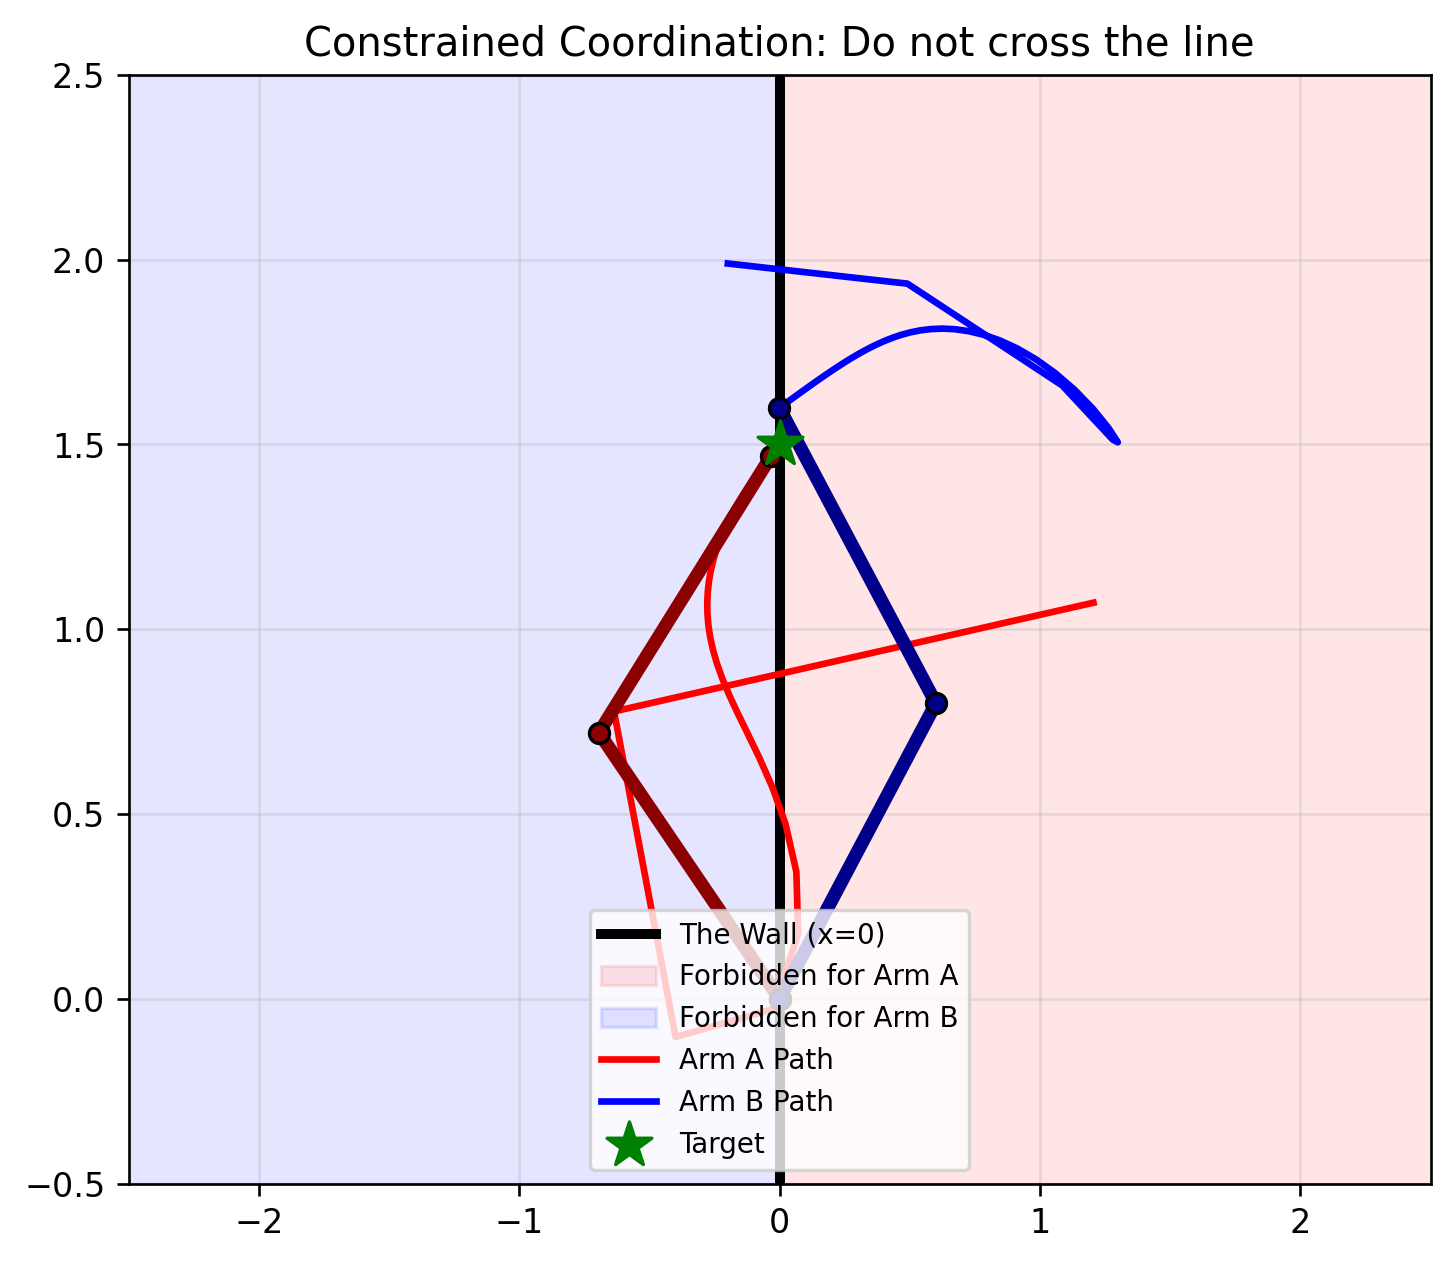

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# --- 3. Priors (Drifts) ---
def drift_arm_A(theta): return -1.0 * (theta - torch.tensor([np.pi*0.75, 0.0]))
def drift_arm_B(theta): return -1.0 * (theta - torch.tensor([np.pi*0.25, 0.0]))

# --- 4. Training with Workspace Constraints ---
steps = 40 # Slightly more steps for precision near the wall
dt = 1.0 / steps
batch_size = 64
epochs = 1000

ctrl = ControlNet()
optimizer = optim.Adam(ctrl.parameters(), lr=0.005)

target_meet_point = torch.tensor([0.0, 1.5]) 

wall_penalty_weight = 100.0 

for epoch in range(epochs):
    optimizer.zero_grad()
    state = torch.randn(batch_size, 4)
    
    control_energy = 0
    workspace_violation = 0
    
    for i in range(steps):
        t = torch.full((batch_size, 1), i * dt)
        
        u = ctrl(state, t)
        b_A = drift_arm_A(state[:, 0:2])
        b_B = drift_arm_B(state[:, 2:4])
        drift = torch.cat([b_A + u[:,:2], b_B + u[:,2:]], dim=1)
        state = state + drift * dt + torch.randn_like(state)*np.sqrt(dt)*0.05
        
        pos_A = forward_kinematics(state[:, 0:2]) # [batch, 2]
        pos_B = forward_kinematics(state[:, 2:4]) # [batch, 2]
        
        violation_A = torch.relu(pos_A[:, 0] - 0.0) 
        
        violation_B = torch.relu(0.0 - pos_B[:, 0])
        
        workspace_violation += torch.mean(violation_A**2 + violation_B**2) * dt
        control_energy += torch.mean(u**2) * dt

    pos_A = forward_kinematics(state[:, 0:2])
    pos_B = forward_kinematics(state[:, 2:4])
    dist_loss = torch.mean((pos_A - target_meet_point)**2 + (pos_B - target_meet_point)**2)
    
    loss = dist_loss + (0.01 * control_energy) + (wall_penalty_weight * workspace_violation)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Dist {dist_loss.item():.4f} | Wall Violation {workspace_violation.item():.4f}")

print("\nVisualizing...")
ctrl.eval()
with torch.no_grad():
    state = torch.randn(1, 4)
    traj_A, traj_B = [], []
    
    for i in range(steps):
        t = torch.full((1, 1), i * dt)
        u = ctrl(state, t)
        b_A = drift_arm_A(state[:, 0:2])
        b_B = drift_arm_B(state[:, 2:4])
        state = state + torch.cat([b_A+u[:,:2], b_B+u[:,2:]],dim=1)*dt
        
        traj_A.append(forward_kinematics(state[:, 0:2])[0].numpy())
        traj_B.append(forward_kinematics(state[:, 2:4])[0].numpy())

traj_A = np.array(traj_A)
traj_B = np.array(traj_B)

plt.figure(figsize=(7, 6))

plt.axvline(0, color='black', linewidth=3, label='The Wall (x=0)')
plt.axvspan(0, 3, alpha=0.1, color='red', label='Forbidden for Arm A')
plt.axvspan(-3, 0, alpha=0.1, color='blue', label='Forbidden for Arm B')

plt.plot(traj_A[:,0], traj_A[:,1], 'r-', linewidth=2, label='Arm A Path')
plt.plot(traj_B[:,0], traj_B[:,1], 'b-', linewidth=2, label='Arm B Path')
plt.scatter(0, 1.5, c='green', s=200, marker='*', zorder=10, label='Target')

final_theta = state[0]
def plot_arm(theta, color):
    l1, l2 = 1.0, 1.0
    x1, y1 = l1*np.cos(theta[0]), l1*np.sin(theta[0])
    x2, y2 = x1+l2*np.cos(theta[0]+theta[1]), y1+l2*np.sin(theta[0]+theta[1])
    plt.plot([0, x1, x2], [0, y1, y2], color=color, linewidth=4, marker='o', markeredgecolor='k')

plot_arm(final_theta[0:2], 'darkred')
plot_arm(final_theta[2:4], 'darkblue')

plt.xlim(-2.5, 2.5)
plt.ylim(-0.5, 2.5)
plt.title("Constrained Coordination: Do not cross the line")
plt.legend(loc='lower center', fontsize='small')
plt.grid(True, alpha=0.3)
plt.show()